In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# ▶ 1. Carregar dados
data = pd.read_csv("./data/data_prepro.csv")

# ▶ 2. Recorte de ~29k (exatamente como na sequência 1)
class_counts = data['Attack Type'].value_counts()
selected_classes = class_counts[class_counts > 1950].index
selected = data[data['Attack Type'].isin(selected_classes)]

dfs = []
for name in selected_classes:
    df_class = selected[selected['Attack Type'] == name]
    if len(df_class) > 2500:
        df_class = df_class.sample(n=5000, random_state=0)
    dfs.append(df_class)

df = pd.concat(dfs, ignore_index=True)

# ▶ 3. Separar features e labels
X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

# ▶ 4. train/test split no recorte reduzido
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [11]:
# ▶ 5. Construir o pipeline com SMOTE
size = X_train.shape[1] // 2
pipe = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('ipca', IncrementalPCA(n_components=size, batch_size=500)),
    ('smote', SMOTE(random_state=0)),
    ('clf', RandomForestClassifier(n_estimators=15, max_depth=8, max_features=20, random_state=0))
])

In [12]:
# ▶ 3. treina (fit) **apenas** nos dados de treino
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ipca', IncrementalPCA(batch_size=500, n_components=35)),
                ('smote', SMOTE(random_state=0)),
                ('clf',
                 RandomForestClassifier(max_depth=8, max_features=20,
                                        n_estimators=15, random_state=0))])

In [17]:
import joblib

pipe = joblib.load('modelos/ids_rf_pipeline_full.pkl')

cv = cross_val_score(pipe, X_train, y_train, cv = 5)
print('Random Forest Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv)))
print(f'\nMean cross-validation score: {cv.mean():.2f}')

Random Forest Model 2

Cross-validation scores: 0.9830469644902634, 0.9791523482245131, 0.983730522456462, 0.980980751604033, 0.9796058661778185

Mean cross-validation score: 0.98


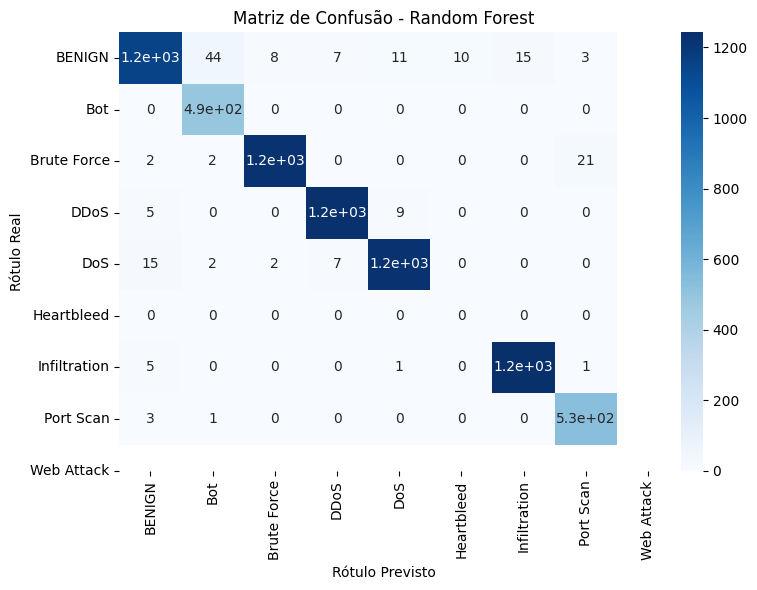

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = pipe.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=pipe.classes_, yticklabels=pipe.classes_)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.tight_layout()
plt.show()

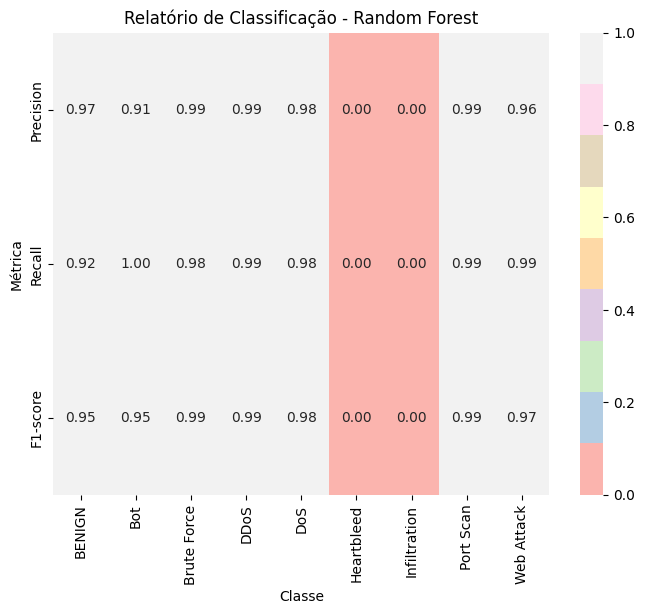

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report


# Geração do relatório de classificação
from sklearn.metrics import classification_report

target_names = pipe.classes_
metrics = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)

precision = [metrics[target]['precision'] for target in target_names]
recall = [metrics[target]['recall'] for target in target_names]
f1 = [metrics[target]['f1-score'] for target in target_names]

data = [precision, recall, f1]
rows = ['Precision', 'Recall', 'F1-score']

plt.figure(figsize=(8, 6))
sns.heatmap(data, cmap='Pastel1', annot=True, fmt='.2f', xticklabels=target_names, yticklabels=rows)
plt.title('Relatório de Classificação - Random Forest')
plt.xlabel('Classe')
plt.ylabel('Métrica')
plt.show()